In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

titanic_data = pd.read_csv('train.csv')
titanic_data

C:\Users\TTM\AppData\Local\Temp\ipykernel_5732\1455286817.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [2]:
titanic_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

## پیش پردازش


In [3]:
label_encoder = LabelEncoder()

titanic_data.fillna(titanic_data.median(numeric_only=True), inplace=True)

titanic_data['Sex'] = label_encoder.fit_transform(titanic_data['Sex'])
titanic_data['Embarked'] = label_encoder.fit_transform(
    titanic_data['Embarked'])
titanic_data['Pclass'] = label_encoder.fit_transform(titanic_data['Pclass'])


X = titanic_data.drop(
    columns=['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId'])
y = titanic_data['Survived']

## معیار فیشر


In [4]:
means_0 = X[y == 0].mean()
means_1 = X[y == 1].mean()
vars_0 = X[y == 0].var()
vars_1 = X[y == 1].var()

fisher_ratios = {}
for column in X.columns:
    fisher_ratio = ((means_1[column] - means_0[column])
                    ** 2) / ((vars_1[column]**2) + (vars_0[column]**2))
    fisher_ratios[column] = fisher_ratio

fisher_ratios_df = pd.DataFrame(list(fisher_ratios.items()), columns=[
                                'feature', 'fisher Ratio'])
print(fisher_ratios_df.sort_values(by='fisher Ratio', ascending=False))

    feature  fisher Ratio
1       Sex      4.500460
0    Pclass      0.398572
6  Embarked      0.080801
4     Parch      0.022468
3     SibSp      0.002130
2       Age      0.000050
5      Fare      0.000033


## انتخاب ویژگی


In [5]:
# ایجاد مدل رگرسیون
model = LogisticRegression(max_iter=200)

# انتخاب ویژگی روبه جلو
sfs = SequentialFeatureSelector(model,
                                k_features='best',
                                forward=True,
                                floating=False,
                                scoring='accuracy',
                                cv=5)  # 5-fold cross-validation

sfs = sfs.fit(X, y)

# استخراج ویژگی ای انتخاب شده
selected_features = X.columns[list(sfs.k_feature_idx_)]
print("Selected Features:", selected_features)

Selected Features: Index(['Pclass', 'Sex', 'SibSp'], dtype='object')


## نمونه برداری بیش از حد

In [6]:
# بررسی توزیع کلاس ها قبل از SMOTE
print("Class distribution before SMOTE:")
print(y.value_counts())

Class distribution before SMOTE:
Survived
0    549
1    342
Name: count, dtype: int64


In [7]:
# اعمال SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# بررسی توزیع کلاس ها بعد از SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
Survived
0    549
1    549
Name: count, dtype: int64


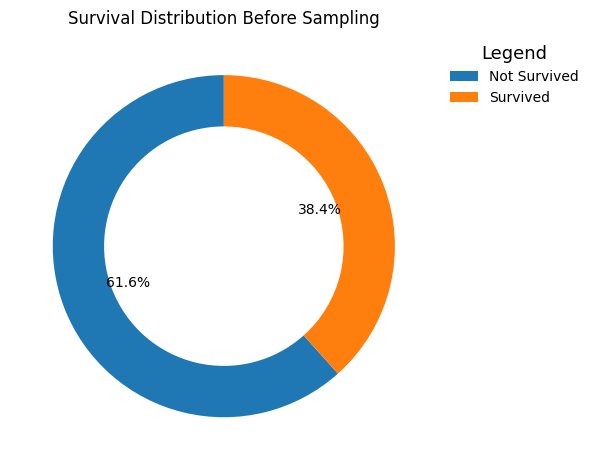

In [8]:
plot_f = y.value_counts()
labels = ['Not Survived', 'Survived']

fig, ax = plt.subplots()
plot_f.plot(kind="pie", autopct='%1.1f%%', startangle=90,
            labels=None, wedgeprops=dict(width=0.3), ax=ax)
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1),
           title='Legend', title_fontsize='13', fontsize='10', frameon=False)
plt.title('Survival Distribution Before Sampling')
plt.ylabel('')
plt.tight_layout()
plt.show()

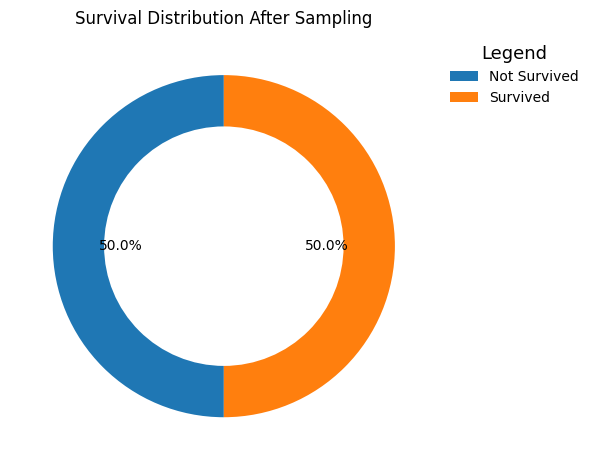

In [9]:
plot_f = y_resampled.value_counts()
labels = ['Not Survived', 'Survived']

fig, ax = plt.subplots()
plot_f.plot(kind="pie", autopct='%1.1f%%', startangle=90,
             labels=None, wedgeprops=dict(width=0.3), ax=ax)
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1),
           title='Legend', title_fontsize='13', fontsize='10', frameon=False)
plt.title('Survival Distribution After Sampling')
plt.ylabel('')
plt.tight_layout()
plt.show()